### isocortex analysis

isocortex analysis
Figure 5 supplement 3

region inside isocortex only (Allen atlas id= 315)- with layers, and sorted based on function

plot number of isocortex area innervated- ipsi and contral, + ipsi vs contra


> Run code once, then:

> Under section- number of isocortex innervated
Replace with 's1' or  's2' for 
```
region='s1'
```


In [3]:
import os
import numpy as np
import seaborn as sns

import pandas as pd
pd.options.mode.chained_assignment = None 
# disable the chained assignment warning

import re

import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm, Normalize
from matplotlib.ticker import MaxNLocator

# use seaborn for easier logrithmic color scale

import itertools
# use itertool to flatten list of list

In [4]:
def find_mousename(text):
    #finds name of mouse that follows the typical LSENS pattern: two letters followed by 3 numbers, ie AL000
    a= re.search('[a-zA-Z]{2}[0-9]{2,3}', text)
    return a[0]

def prep_df_old(df):
    # prepares df so that we only keep the id and total count
    # input is the full path and name of the .csv file
    read_file= pd.read_excel(df)
    
    searchfor = ['/567/', '/343/','/512/']
    cc_cb_bs= read_file.loc[read_file['structure_id_path'].str.contains('|'.join(searchfor), case=False)]
    # select cerebrum 567, brain stem 343 and cerebellum  512 region only 
      
    new= cc_cb_bs.set_index('acronym').T
    new_series=new.loc['counts']

    full_df= new_series.to_frame()
    full_df.rename(columns={'counts': find_mousename(df)}, inplace=1)
    return full_df

def prep_df(df):
    ''' now only include regions belonging to and /343/ brainstem /567/ cerebrum  (but excluding /698/ olfactory areas and /1089/ hippocampal formation that belongs under /567/)'''
    
    # prepares df so that we only keep the id and total count
    # input is the full path and name of the .csv file
    
    read_file= pd.read_excel(df)
    
    searchfor = ['/567/', '/343/']
    cc_cb= read_file.loc[read_file['structure_id_path'].str.contains('|'.join(searchfor), case=False)]
    # select cerebrum 567, brain stem 343 only
    
    search_exclude = ['/1089/', '/698/']
    cc_cb_clean= cc_cb.loc[~cc_cb['structure_id_path'].str.contains('|'.join(search_exclude), case=False)]
    # exclude regions under 698 olfactory areas and 1089 hippocampal formation
      
    new= cc_cb_clean.set_index('acronym').T
    new_series=new.loc['counts']

    full_df= new_series.to_frame()
    full_df.rename(columns={'counts': find_mousename(df)}, inplace=1)
    return full_df

def combine_df_old(folder,list_of_fname,inner=False):
    # combine multiple data frames, keeping only mouse name, region id and amount of um
    # by default, returns all of the regions that at least one brain that projects to it
    # if inner=True, then only return regions that overlaps in all brains
    
    #initialize a dataframe which will later be removed
    full_name_initial=os.path.join(folder, list_of_fname[0])
    full_df=prep_df(full_name_initial)
    
    if inner==True:
        for i in (list_of_fname):
            new_df=prep_df(os.path.join(folder, i))
            full_df=full_df=pd.concat([full_df, new_df],axis=1, join='inner')

    else: 
        for i in (list_of_fname):
            new_df=prep_df(os.path.join(folder, i))
            full_df=pd.concat([full_df, new_df],axis=1)

    full_df=full_df.T.iloc[1:]
    return full_df

def combine_df(folder,list_of_fname):
    # combine multiple data frames, keeping only mouse name, region id and amount of um
    # by default, returns all of the regions that at least one brain that projects to it
    # if inner=True, then only return regions that overlaps in all brains
    
    #initialize a dataframe which will later be removed
    full_df=[]
    
    for i in (list_of_fname):
        new_df=prep_df(os.path.join(folder, i))
        full_df.append(new_df)

    full_df=pd.concat(full_df,axis=1)
    return full_df


def combine_df_specific(folder,list_of_fname,region_id=''):
    
    '''    # combine multiple data frames, keeping only mouse name, region id and amount of voxels
    by default, returns all of the regions that at least one brain that projects to it
    region_id specifies to look for brain regions only belonging to brainstem(343), cerebrum(567) or all others('')'''

    #initialize a list for data frames to combine
    df_list = []
    for i in parent_axons:
        this_df = prep_df_specific(os.path.join(folder, i),region_id=region_id).T
        df_list.append(this_df)
    full_df = pd.concat(df_list)

    return full_df

def get_parent_excel(subregion_df):
    ''' quantify axon counts in broader anatomical regions
    regions with depth>6 will be grouped one level up
    '''
    

    axon_sub=subregion_df.sort_values(by=['average'])
    axon_sub.sort_values(by= 'graph_order',axis=0, inplace=True)

    needsgroup=axon_sub[axon_sub.depth>6]
    noneedsgroup=axon_sub[axon_sub.depth<=6]

    parent= parent_df(needsgroup)

    complete1=noneedsgroup.append(parent)

    complete=clean_duplicate(complete1)

    complete.sort_values('average',ascending=False, inplace=True)
    
    return complete

def parent_df(df):
    # group dataframe by parent id structure
    grouped_pd=df.groupby(['parent_structure_id'],as_index=False).sum()
    d= {'id': grouped_pd.parent_structure_id.astype(int), 'average': grouped_pd.average}
    grouped_pd2= pd.DataFrame(data=d)
    result = pd.merge(grouped_pd2, atlas_labels, on=["id"])
    result.sort_values(['average'], ascending=True, inplace=True)
    # result is the final pd

    return result

def clean_duplicate(df):
    '''This is needed again to account for parent regions that have its subregion incompletely covers the parent areas.
    A painful example is Zona incerta, since it has a depth of 6, after group by parents it will show up twice with different counts where we simply just add the two counts'''
    
    df2=df.groupby(['acronym'],as_index=False, sort=False).sum()
    d= {'acronym': df2.acronym, 'average': df2.average}
    grouped_pd2= pd.DataFrame(data=d)
    result = pd.merge(grouped_pd2, atlas_labels, on=["acronym"])
    # this merging is required because pd.groupby will drop 'useless columns' such as depth, structure id path and other useful ones!! So we fetch them back here..
    # Probably have better ways of doing it...
    
    return result

def prep_df2(df, genotype_name):
    ''' now only include regions belonging to and /343/ brainstem /567/ cerebrum  (but excluding /698/ olfactory areas and /1089/ hippocampal formation that belongs under /567/)'''
    
    # prepares df so that we only keep the id and total count
    # input is the full path and name of the .csv file
    
    read_file= df
    
    searchfor = ['/567/', '/343/']
    cc_cb= read_file.loc[read_file['structure_id_path'].str.contains('|'.join(searchfor), case=False)]
    # select cerebrum 567, brain stem 343 only
    
    search_exclude = ['/1089/', '/698/']
    cc_cb_clean= cc_cb.loc[~cc_cb['structure_id_path'].str.contains('|'.join(search_exclude), case=False)]
    # exclude regions under 698 olfactory areas and 1089 hippocampal formation
      
    new= cc_cb_clean.set_index('acronym').T
    new_series=new.loc['average']

    full_df= new_series.to_frame()
    full_df.rename(columns={'average': genotype_name}, inplace=1)
    return full_df

In [5]:
working_directory= r'E:\CodeTest'
# this directory should contain folders Horizontal_Axon, ARA_25_micron_mhd_ccf2017, and file injection_sites_results_expanded


atlas_labels=pd.read_csv(f'{working_directory}\ARA_25_micron_mhd_ccf2017\labels.csv')
#load atlas labels

region_id='315'

#### prepare data

In [9]:
region= 's1'

folder= f'{working_directory}\\{region}_average'

files= [ i for i  in os.listdir(folder) if '_avg_' in i]

column_order= ['ras','scn','tlx','rbp','sim','nts']
# arrange order for genotype for plotting

In [12]:
left_axons_avg= [ i for i  in files if 'left' in i]
#change side to right and Rparent for the other hemisphere!

full_df= []
# create empty list to store data frames

for i in left_axons_avg:
    genotype= i[3:6]
    full_name= os.path.join(folder, i)
    
    this_df= pd.read_excel(full_name)
    # read the files, note that these files still contain layer information
    
    this_temp= get_parent_excel(this_df)
    # transform the specific df into parent categories
    
    specific_df=this_temp.loc[this_temp['structure_id_path'].str.contains(f'/{region_id}/', case=False)]
    # isolate those from isocortex
    
    specific_df.sort_values(by='graph_order', inplace=True) 
    # sort by graph_order so relevant regions stay together
    
    temp= prep_df2(specific_df, genotype)
    # prepare to only extract acronym and genotype name
    
    full_df.append(temp)

full_df_left= pd.concat(full_df,axis=1)

final_left=full_df_left[column_order]

df=final_left.fillna(0.0)

C:\Users\liu\AppData\Local\Temp\ipykernel_21728\3421460779.py:112: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  complete1=noneedsgroup.append(parent)
C:\Users\liu\AppData\Local\Temp\ipykernel_21728\3421460779.py:112: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  complete1=noneedsgroup.append(parent)
C:\Users\liu\AppData\Local\Temp\ipykernel_21728\3421460779.py:112: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  complete1=noneedsgroup.append(parent)
C:\Users\liu\AppData\Local\Temp\ipykernel_21728\3421460779.py:112: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  complete1=noneedsgroup.append(parent)
C:\Users\liu\AppData\Local\Temp\ipykerne

In [13]:
right_axons_avg= [ i for i  in files if 'right' in i]
#change side to right and Rparent for the other hemisphere!

full_df= []
# create empty list to store data frames

for i in right_axons_avg:
    genotype= i[3:6]
    full_name= os.path.join(folder, i)
    
    this_df= pd.read_excel(full_name)
    # read the files, note that these files still contain layer information
    
    this_temp= get_parent_excel(this_df)
    # transform the specific df into parent categories
    
    specific_df=this_temp.loc[this_temp['structure_id_path'].str.contains(f'/{region_id}/', case=False)]
    # isolate region only inside isocortex

    specific_df.sort_values(by='graph_order', inplace=True) 
    # sort by graph_order so relevant regions stay together
    
    
    temp= prep_df2(specific_df, genotype)
    # prepare to only extract acronym and genotype name
    
    full_df.append(temp)

full_df_right= pd.concat(full_df,axis=1)

final_r=full_df_right[column_order]

df_r=final_r.fillna(0.0)

C:\Users\liu\AppData\Local\Temp\ipykernel_21728\3421460779.py:112: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  complete1=noneedsgroup.append(parent)
C:\Users\liu\AppData\Local\Temp\ipykernel_21728\3421460779.py:112: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  complete1=noneedsgroup.append(parent)
C:\Users\liu\AppData\Local\Temp\ipykernel_21728\3421460779.py:112: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  complete1=noneedsgroup.append(parent)
C:\Users\liu\AppData\Local\Temp\ipykernel_21728\3421460779.py:112: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  complete1=noneedsgroup.append(parent)
C:\Users\liu\AppData\Local\Temp\ipykerne

In [15]:
# repeat for s2

region= 's2'

folder= f'{working_directory}\\{region}_average'


files= [ i for i  in os.listdir(folder) if '_avg_' in i]

left_axons_avg= [ i for i  in files if 'left' in i]
#change side to right and Rparent for the other hemisphere!

full_df= []
# create empty list to store data frames

for i in left_axons_avg:
    genotype= i[3:6]
    full_name= os.path.join(folder, i)
    
    this_df= pd.read_excel(full_name)
    # read the files, note that these files still contain layer information
    
    this_temp= get_parent_excel(this_df)
    # transform the specific df into parent categories
    
    specific_df=this_temp.loc[this_temp['structure_id_path'].str.contains(f'/{region_id}/', case=False)]
    # isolate those from isocortex
    specific_df.sort_values(by='graph_order', inplace=True) 
    # sort by graph_order so relevant regions stay together
    
    temp= prep_df2(specific_df, genotype)
    # prepare to only extract acronym and genotype name
    
    full_df.append(temp)

full_df_left= pd.concat(full_df,axis=1)

final_left=full_df_left[column_order]

df_s2=final_left.fillna(0.0)


right_axons_avg= [ i for i  in files if 'right' in i]
#change side to right and Rparent for the other hemisphere!


full_df= []
# create empty list to store data frames

for i in right_axons_avg:
    genotype= i[3:6]
    full_name= os.path.join(folder, i)
    
    this_df= pd.read_excel(full_name)
    # read the files, note that these files still contain layer information
    
    this_temp= get_parent_excel(this_df)
    # transform the specific df into parent categories
    
    specific_df=this_temp.loc[this_temp['structure_id_path'].str.contains(f'/{region_id}/', case=False)]
    # isolate those from isocortex
    
    specific_df.sort_values(by='graph_order', inplace=True) 
    # sort by graph_order so relevant regions stay together
    
    temp= prep_df2(specific_df, genotype)
    # prepare to only extract acronym and genotype name
    
    full_df.append(temp)

full_df_right= pd.concat(full_df,axis=1)

final_r=full_df_right[column_order]

df_r_s2=final_r.fillna(0.0)


C:\Users\liu\AppData\Local\Temp\ipykernel_21728\3421460779.py:112: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  complete1=noneedsgroup.append(parent)
C:\Users\liu\AppData\Local\Temp\ipykernel_21728\3421460779.py:112: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  complete1=noneedsgroup.append(parent)
C:\Users\liu\AppData\Local\Temp\ipykernel_21728\3421460779.py:112: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  complete1=noneedsgroup.append(parent)
C:\Users\liu\AppData\Local\Temp\ipykernel_21728\3421460779.py:112: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  complete1=noneedsgroup.append(parent)
C:\Users\liu\AppData\Local\Temp\ipykerne

In [16]:
all_df=pd.concat([df,df_r, df_s2,df_r_s2],axis=1)
all_df.fillna(0, inplace=True)

#### plot heatmaps

change region= '' to 's1' or 's2' accordingly

In [203]:
split_interval= int((len(all_df.columns))/4)
#split the length of both data frame in 4 pieces, the four section order section is always s1 left, s1 right, s2 left , s2 right as a result of our concatenation

leftside_top= all_df.T.iloc[0:split_interval]
rightside_top=all_df.T.iloc[split_interval: split_interval*2]
# tranpose so we can use iloc to split back to left and right

leftside_top=leftside_top.T
rightside_top=rightside_top.T
#transpose back


leftside_s2_top= all_df.T.iloc[split_interval*2:split_interval*3]
rightside_s2_top=all_df.T.iloc[split_interval*3:-1]
# tranpose so we can use iloc to split back to left and right
# for rightside s2, drop the last column because it is the average!

leftside_s2_top=leftside_s2_top.T
rightside_s2_top=rightside_s2_top.T
#transpose backns

In [206]:
outdir = f"{working_directory}\s1_s2"
#os.mkdir(outdir)

all_df.to_excel(f'{working_directory}\s1_s2\Group_averages_isocortex.xlsx')
                
# save the data somewhere

In [213]:
region= 's2'
# change to 's1' or 's2' and repeat

if region== 's1':
    df_left= leftside_top
    df_right= rightside_top
else:
    region= 's2'
    df_left= leftside_s2_top
    df_right= rightside_s2_top

outdir = f'{working_directory}\\{region}_result'

In [208]:
vmin=1
vmax=2500

# set vmin and vmax for color scale

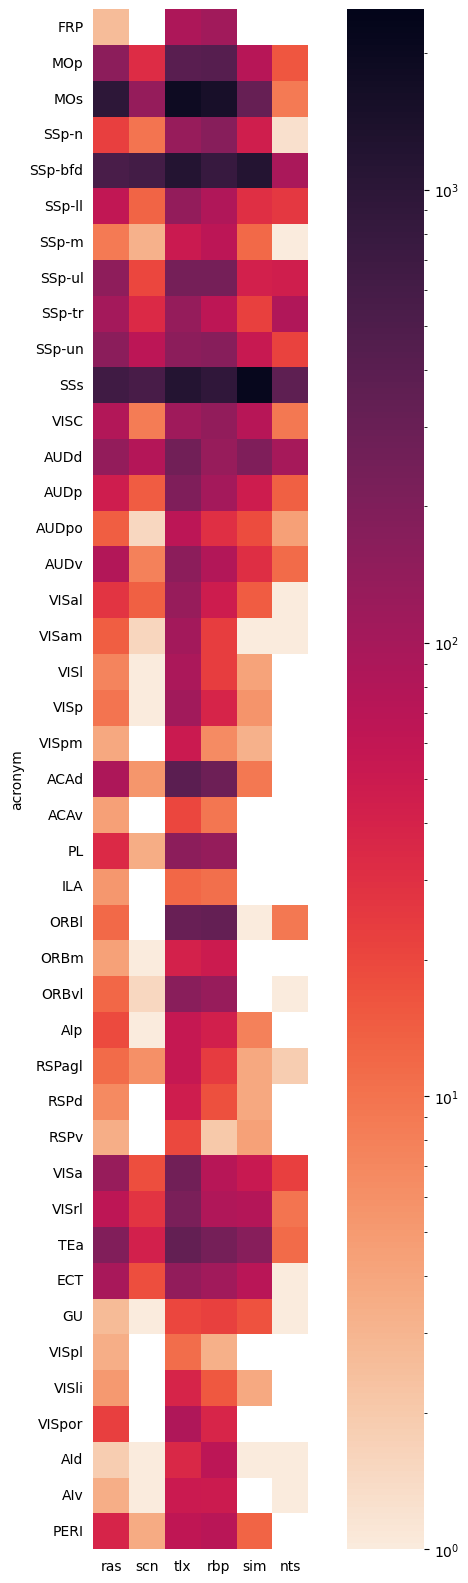

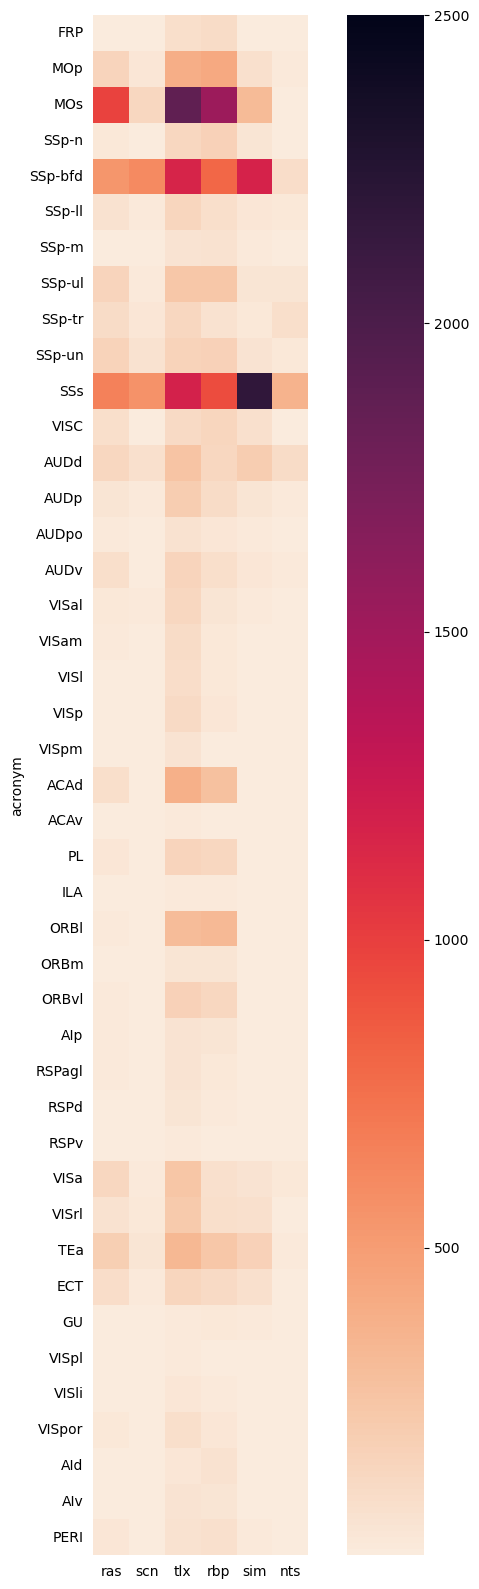

In [214]:
fig, ax = plt.subplots(figsize=(10,20))
g1= sns.heatmap(df_left, 
                norm=LogNorm(vmin= vmin, vmax= vmax),
                cmap="rocket_r",
                square=True,
                linewidths=0.0,
                rasterized=True)

g1.tick_params(bottom=False, left=False)
# disable ticks because it is such a mess in illustrator!

plt.rcParams['svg.fonttype'] = 'none'
# so text stay as text not paths!

plt.savefig(f'{outdir}\left_heatmap_avg_isocortex_logscale.svg')

#plt.show()

# linear scale
fig, ax = plt.subplots(figsize=(10,20))
g1= sns.heatmap(df_left, 
                cmap="rocket_r",
                square=True,
                vmin= vmin,
                vmax=vmax, 
                linewidths=0.0,
                rasterized=True)

g1.tick_params(bottom=False, left=False)
# disable ticks because it is such a mess in illustrator!

plt.rcParams['svg.fonttype'] = 'none'
# so text stay as text not paths!

plt.savefig(f'{outdir}\\left_heatmap_avg_isocortex_linearscale.svg')

#plt.show()

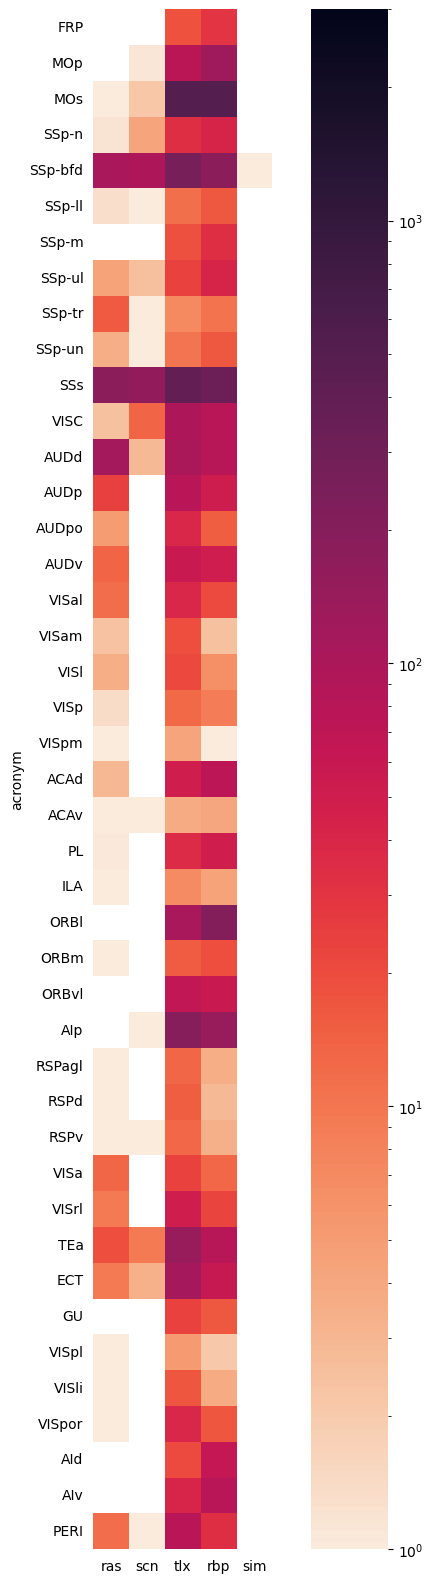

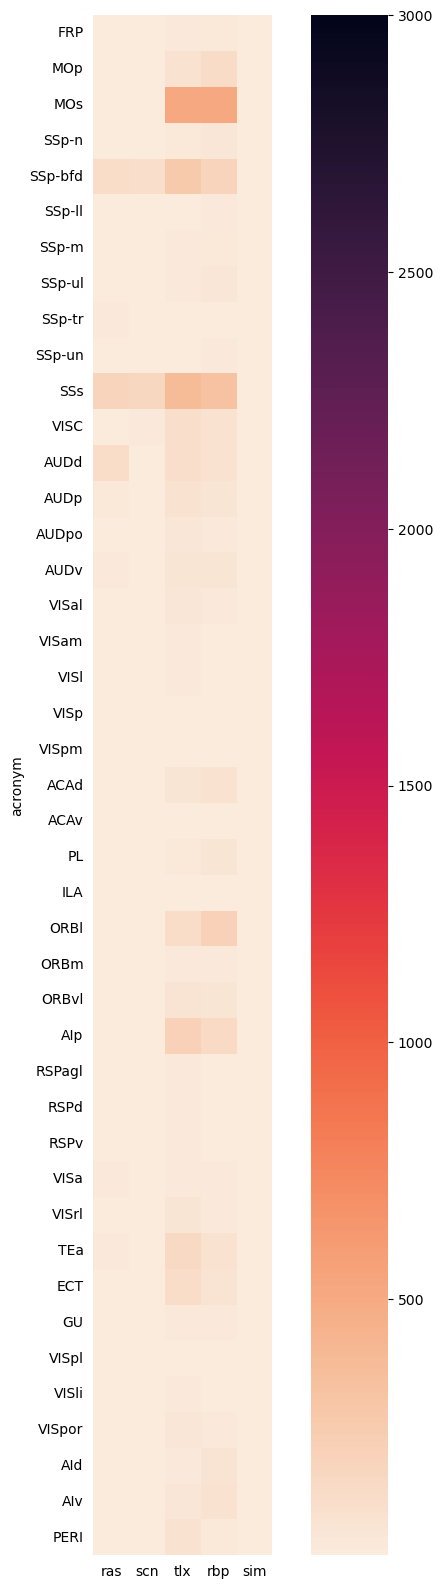

In [215]:
# repeat for right side
fig, ax = plt.subplots(figsize=(10,20))
g1= sns.heatmap(df_right, 
                norm=LogNorm(vmin=1, vmax= 3000),
                cmap="rocket_r",
                square=True,
                linewidths=0.0,
                rasterized=True)

g1.tick_params(bottom=False, left=False)
# disable ticks because it is such a mess in illustrator!

plt.rcParams['svg.fonttype'] = 'none'
# so text stay as text not paths!

plt.savefig(f'{outdir}\\right_heatmap_avg_isocortex_logscale.svg')


# linear scale, do not change vmin and vmax!! 1 and 3000
# repeat for right side
fig, ax = plt.subplots(figsize=(10,20))
g1= sns.heatmap(df_right, 
                cmap="rocket_r",
                square=True,
                vmin= 1,
                vmax=3000, 
                linewidths=0.0,
                rasterized=True)

g1.tick_params(bottom=False, left=False)
# disable ticks because it is such a mess in illustrator!

plt.rcParams['svg.fonttype'] = 'none'
# so text stay as text not paths!

plt.savefig(f'{outdir}\\right_heatmap_avg_isocortex_linearscale.svg')

#plt.show()

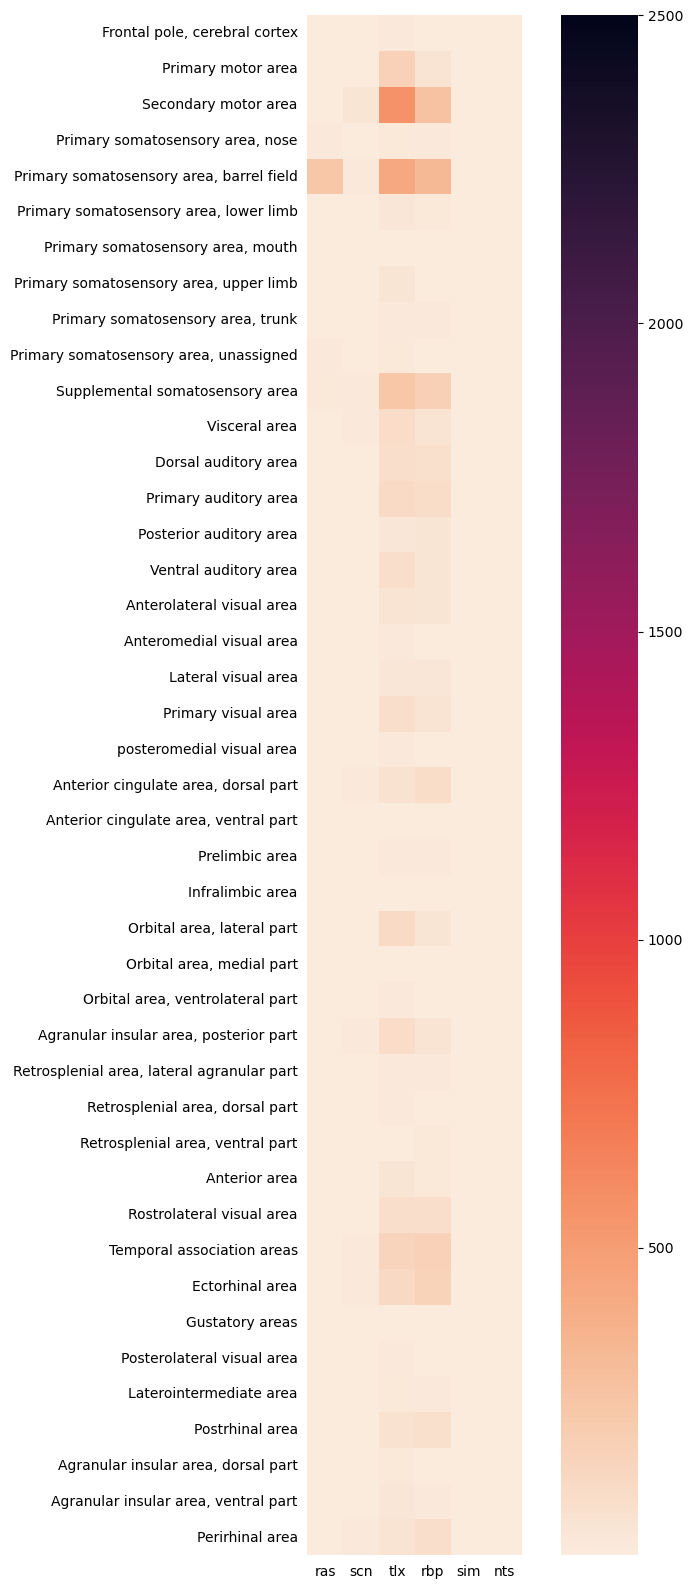

In [212]:
# generate a list of full name for the ordered acronyms

# This cell only need to be ran once for illustrator purposes-> get full labels instead of acronym

full_name=[]

for i in df_right.index:
    name=atlas_labels.query(f"acronym== '{i}'").name.values[0]
    full_name.append(name)

df_right_full = pd.DataFrame(df_right.values, index = full_name,
                  columns = df_right.columns)

# plot just one dataframe to get the row labels- then could just copy in illustrator

# linear scale, do not change vmin and vmax!! 1 and 6000
fig, ax = plt.subplots(figsize=(10,20))
g1= sns.heatmap(df_right_full,
                #right_50.drop(columns= 'Average'), 
                cmap="rocket_r",
                square=True,
                vmin= vmin,
                vmax= vmax, 
                linewidths=0.0,
                rasterized=True)

g1.tick_params(bottom=False, left=False)
# disable ticks because it is such a mess in illustrator!

plt.rcParams['svg.fonttype'] = 'none'
# so text stay as text not paths!

plt.savefig(f'{outdir}\\right_heatmap_avg_isocortex_linearscale_fullname.svg')

#plt.show()

#### number of isocortex innervated

In [6]:
def prep_df_specific(df,region_id=''):
    '''Look for regions belong to one of the group by specifying region_id = : 
    343 brainstem
    567 cerebrum
    leave empty for everything else
    ie prep_df_specific(path_to_df) gives regions not belonging to brainstem or cerebrum
    prep_df_specific(path_to_df, region_id =343) gives regions belonging to brainstem only
    '''
    
    # prepares df so that we only keep the id and total count
    # input is the full path and name of the .csv file
    read_file= pd.read_excel(df)
    
    #new= read_file.set_index('id').sort_values(by='graph_order').T
    #This lines sorts the region ids according to its graph order, such that related regions are ordered together 
    # ie, barrel field layers are grouped together
    # Note that this order would be disrupted when you have to later concatenate dfs with different columns...so need to rearrange later
    
    if region_id:
        specific_df=read_file.loc[read_file['structure_id_path'].str.contains(f'/{region_id}/', case=False)]
    else:
        searchfor = ['/343/','/567/']
        specific_df= read_file.loc[~read_file['structure_id_path'].str.contains('|'.join(searchfor), case=False)]            
    
    
    search_exclude = ['/1089/', '/698/']
    specific_df_clean= specific_df.loc[~specific_df['structure_id_path'].str.contains('|'.join(search_exclude), case=False)]
    # exclude regions under 698 olfactory areas and 1089 hippocampal formation
    
    new= specific_df_clean.set_index('acronym').T
    new_series=new.loc['counts']

    full_df= new_series.to_frame()
    full_df.rename(columns={'counts': find_mousename(df)}, inplace=1)
    return full_df

In [19]:
# load individual files

region='s1'

folder= f'{working_directory}\\{region}_result'
outdir= f'{working_directory}\\{region}_result'
# change s1 to s2

region_id='315'
# 315 isocortex, 688 cerebral cortex, 343 brainstem


files= [ i for i  in os.listdir(folder) if 'with_counts' in i]

atlas_labels=pd.read_csv(f'{working_directory}\ARA_25_micron_mhd_ccf2017\labels.csv')

In [20]:
if region== 's1':

    column_order= ['AL254', 'AL255', 'AL257','AL290','AL291','AL292','AL293','AL213','AL313','AL314','AL211','AL318', 'AL207','AL209','AL273','AL274','AL285','AL311']
    # for verified s1 injections as of september .2023

else :
    column_order= ['AL303','AL332','AL333','AL290','AL292','AL323', 'AL278', 'AL280', 'AL319', 'AL288', 'AL326', 'AL327','AL281', 'AL286', 'AL321', 'AL322', 'AL274', 'AL310', 'AL330']
    #for s2 injections as of June.2023

In [21]:
if region== 's1':
    genotype_list= ['Rasgrf2dCre','Rasgrf2dCre','Rasgrf2dCre','Scnn1aCre','Scnn1aCre','Scnn1aCre','Scnn1aCre', 'Tlx3Cre','Tlx3Cre','Tlx3Cre',
                    'Rbp4Cre','Rbp4Cre', 'Sim1Cre','Sim1Cre','Sim1Cre', 'Ntsr1Cre','Ntsr1Cre','Ntsr1Cre']
else:
    genotype_list= ['Rasgrf2dCre','Rasgrf2dCre','Rasgrf2dCre','Scnn1aCre','Scnn1aCre', 'Scnn1aCre', 'Tlx3Cre','Tlx3Cre','Tlx3Cre',
                'Rbp4Cre','Rbp4Cre', 'Rbp4Cre', 'Sim1Cre','Sim1Cre','Sim1Cre', 'Sim1Cre', 'Ntsr1Cre','Ntsr1Cre','Ntsr1Cre']


In [22]:
side='left'
parent_axons= [ i for i  in os.listdir(folder) if 'Lparent' in i]

axonal_df= combine_df_specific(folder, parent_axons,region_id)
axonal_df=axonal_df.T

side='right'
parent_axons= [ i for i  in os.listdir(folder) if 'Rparent' in i]

axonal_df_r= combine_df_specific(folder, parent_axons,region_id)
axonal_df_r=axonal_df_r.T

In [ ]:
threshold=np.percentile(all_df.values, 25)
# anything below 26  percentile is 0.. so lots of data with 0
print(f'threshold for axon density cut off is {threshold}')

In [23]:
left_regions_filtered= (axonal_df >= threshold)

# filter values, only keep those with a value of 1 and above

left_region_count=left_regions_filtered[column_order].sum(axis=0)

right_regions_filtered= (axonal_df_r >= threshold)

# filter values, only keep those with a value of 1 and above

right_region_count=right_regions_filtered[column_order].sum(axis=0)

In [24]:
data=pd.concat([left_region_count, right_region_count], axis=1)
# concatenate the left and righ side for plotting

data.reset_index(inplace= True)
data.rename(columns={'index':'sample_id', 0:'left', 1: 'right'}, inplace=True)

data['genotype'] = genotype_list


In [26]:
outdir = f"{working_directory}\s1_s2"
#os.mkdir(outdir)

data.to_excel(f'{working_directory}\\s1_s2\\{region}_isocortex_number.xlsx')
                
# save the data somewhere

Text(0.5, 0.98, 's2_samples')

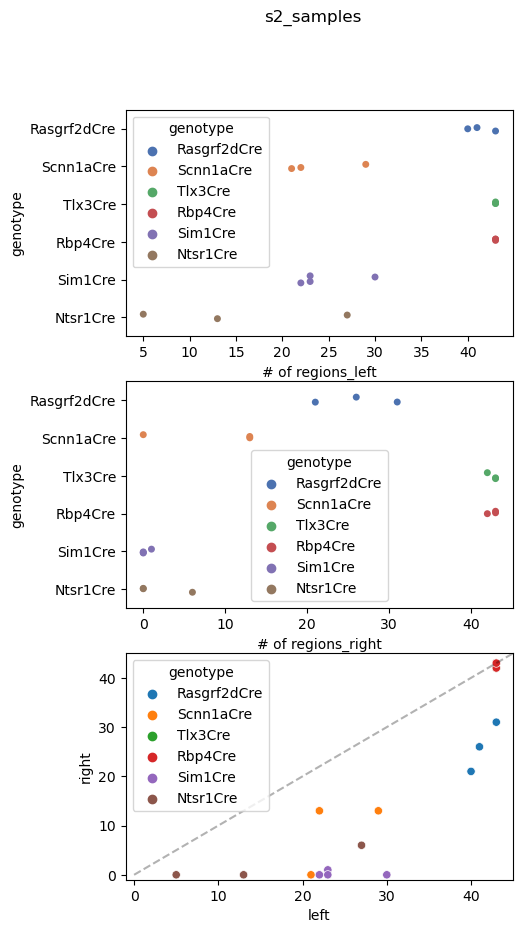

In [15]:
fig, ax= plt.subplots(3,1,figsize=(5,10))

sns.stripplot(data=data, x="left", y="genotype", hue='genotype', palette="deep", ax=ax[0])
ax[0].set_xlabel('# of regions_left')

sns.stripplot(data=data, x="right", y="genotype", hue= 'genotype', palette="deep", ax=ax[1])
ax[1].set_xlabel('# of regions_right')

# alternatively, plot left vs right
sns.scatterplot(x='left', y='right', hue='genotype',  data=data, ax=ax[2])
ax[2].plot([0, 45], [0, 45], ls="--", c="k", alpha= 0.3)
ax[2].set_xlim(-1,45)
ax[2].set_ylim(-1,45)

fig.suptitle(f'{region}_samples')

plt.savefig(f'{outdir}\\{region}_isocortex.svg')

In [25]:
data.groupby(['genotype']).mean()

,left,right
genotype,,
Ntsr1Cre,19.333333,1.666667
Rasgrf2dCre,39.000000,9.666667
Rbp4Cre,43.000000,42.500000
Scnn1aCre,40.000000,30.250000
Sim1Cre,30.666667,1.333333
Tlx3Cre,43.000000,43.000000


In [26]:
data.groupby(['genotype']).std()

,left,right
genotype,,
Ntsr1Cre,15.631165,2.886751
Rasgrf2dCre,5.196152,5.507571
Rbp4Cre,0.000000,0.707107
Scnn1aCre,1.632993,4.193249
Sim1Cre,4.163332,0.577350
Tlx3Cre,0.000000,0.000000
